In [0]:
%matplotlib inline

# CIFAR-10 - Keras

## Loading the dataset

In [0]:
import numpy as np

from keras.datasets import cifar10
from keras.utils.np_utils import to_categorical   


(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Using TensorFlow backend.


170500096/170498071 [==============================] - 11s 0us/step


### Examining the dataset

In [0]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 1)
Shape of test data:
(10000, 32, 32, 3)
(10000, 1)


We have 50000 training and 10000 test images in the dataset. The images have a structure of (32,32,3) which correspond to (width, height, RGB).

For each image there is a corresponding label, which is a class index.

Example training images and their labels: [6, 9, 9, 4, 1]
Corresponding classes for the labels: ['frog', 'truck', 'truck', 'deer', 'automobile']


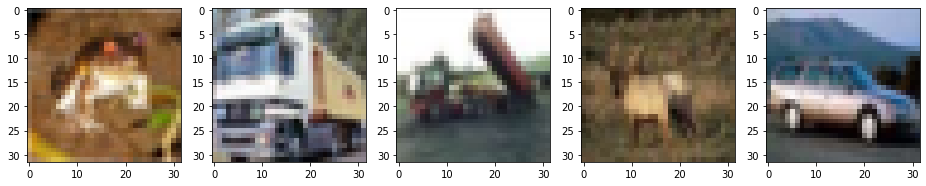

In [0]:
import matplotlib.pyplot as plt

cifar_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
print('Example training images and their labels: ' + str([x[0] for x in y_train[0:5]])) 
print('Corresponding classes for the labels: ' + str([cifar_classes[x[0]] for x in y_train[0:5]]))

f, axarr = plt.subplots(1, 5)
f.set_size_inches(16, 6)

for i in range(5):
    img = X_train[i]
    axarr[i].imshow(img)
plt.show()

### Preparing the dataset

First we are going to use a Multilayer Perceptron to classify our images.

Instead of class indices we will use one-hot encoded vectors to represent the labels of the samples. We also need to vectorize the images, since the MLP will take a 3072-dimensional vector as the input. When working with images, a simple way to normalize our data is to fit it within the 0 to 1 range.

In [0]:
# Transform label indices to one-hot encoded vectors

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Transform images from (32,32,3) to 3072-dimensional vectors (32*32*3)

X_train = np.reshape(X_train,(50000,3072))
X_test = np.reshape(X_test,(10000,3072))
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Normalization of pixel values (to [0-1] range)

X_train /= 255
X_test /= 255

## MLP classifier

The MLPs are capable of modelling complex classification problems which are typically not linearly separable.

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

model = Sequential()
model.add(Dense(256, activation='relu', input_dim=3072))
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))
sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Training the MLP

Let's train our model now! We will store the training loss values and metrics in a history object, so we can visualize the training process later.

We are going to train the model for some epochs, using a batch size of 32 and a validation split of 0.2. The latter means that 20% of our training data will be used as validation samples (in practice however it is advised to separate the validation data from the training data altogether).

In [0]:
epochs=15

In [0]:
history = model.fit(X_train,y_train, epochs=epochs, batch_size=32, verbose=2, validation_split=0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 5s - loss: 1.8374 - accuracy: 0.3348 - val_loss: 1.7372 - val_accuracy: 0.3785
Epoch 2/15
 - 3s - loss: 1.6662 - accuracy: 0.4015 - val_loss: 1.6120 - val_accuracy: 0.4211
Epoch 3/15
 - 3s - loss: 1.5929 - accuracy: 0.4314 - val_loss: 1.6377 - val_accuracy: 0.4167
Epoch 4/15
 - 3s - loss: 1.5448 - accuracy: 0.4454 - val_loss: 1.5954 - val_accuracy: 0.4444
Epoch 5/15
 - 3s - loss: 1.5081 - accuracy: 0.4573 - val_loss: 1.5787 - val_accuracy: 0.4399
Epoch 6/15
 - 3s - loss: 1.4831 - accuracy: 0.4700 - val_loss: 1.5897 - val_accuracy: 0.4411
Epoch 7/15
 - 3s - loss: 1.4556 - accuracy: 0.4795 - val_loss: 1.5136 - val_accuracy: 0.4608
Epoch 8/15
 - 3s - loss: 1.4328 - accuracy: 0.4849 - val_loss: 1.5630 - val_accuracy: 0.4564
Epoch 9/15
 - 3s - loss: 1.4116 - accuracy: 0.4929 - val_loss: 1.5473 - val_accuracy: 0.4479
Epoch 10/15
 - 3s - loss: 1.3932 - accuracy: 0.4992 - val_loss: 1.4898 - val_accuracy: 0.4828
Epoch 11/15
 - 3s -

With this simple function we will be able to plot our training history.

In [0]:
def plotLosses(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

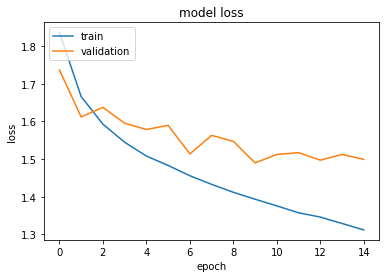

In [0]:
plotLosses(history)

### Evaluating the MLP

To get a measure of our model's performance we need to evaluate it using the test samples:

In [0]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[1.482691801261902, 0.4821000099182129]


## CNN classifier

So far, we have not exploited that we are working with images. By using [Convolutional Neural Networks](https://cs231n.github.io/convolutional-networks/), we can take advantage of the special structure of the inputs. Convolutions are [translation invariant](https://stats.stackexchange.com/questions/208936/what-is-translation-invariance-in-computer-vision-and-convolutional-neural-netwo), and this makes them especially well suited for processing images.

### Preparing the dataset

In [0]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [0]:
print("Shape of training data:")
print(X_train.shape)
print(y_train.shape)
print("Shape of test data:")
print(X_test.shape)
print(y_test.shape)

Shape of training data:
(50000, 32, 32, 3)
(50000, 10)
Shape of test data:
(10000, 32, 32, 3)
(10000, 10)


### Creating CNN model

We will use two convolutional layers, each with 32 filters a kernel size of (3,3) and ReLU activation function.

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

### Training the CNN


In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 10s - loss: 1.4973 - accuracy: 0.4593 - val_loss: 1.1804 - val_accuracy: 0.5836
Epoch 2/15
 - 5s - loss: 1.0688 - accuracy: 0.6223 - val_loss: 1.0464 - val_accuracy: 0.6388
Epoch 3/15
 - 5s - loss: 0.8406 - accuracy: 0.7027 - val_loss: 1.0233 - val_accuracy: 0.6475
Epoch 4/15
 - 5s - loss: 0.6236 - accuracy: 0.7809 - val_loss: 1.0311 - val_accuracy: 0.6640
Epoch 5/15
 - 5s - loss: 0.4268 - accuracy: 0.8495 - val_loss: 1.2086 - val_accuracy: 0.6567
Epoch 6/15
 - 5s - loss: 0.2733 - accuracy: 0.9032 - val_loss: 1.3911 - val_accuracy: 0.6510
Epoch 7/15
 - 5s - loss: 0.1870 - accuracy: 0.9354 - val_loss: 1.5072 - val_accuracy: 0.6585
Epoch 8/15
 - 5s - loss: 0.1458 - accuracy: 0.9505 - val_loss: 1.7389 - val_accuracy: 0.6572
Epoch 9/15
 - 5s - loss: 0.1181 - accuracy: 0.9608 - val_loss: 1.8885 - val_accuracy: 0.6533
Epoch 10/15
 - 5s - loss: 0.0853 - accuracy: 0.9719 - val_loss: 2.0826 - val_accuracy: 0.6593
Epoch 11/15
 - 5s 

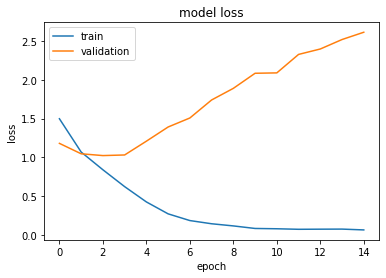

In [0]:
plotLosses(history)

### Evaluating the CNN

In [0]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[2.7222285110473634, 0.6409000158309937]


As we can see, the CNN reached significantly higher accuracy than the MLP classifier, but overfitting occured during the training of our model. To avoid this, the use of some regularization techniques would be advised.

## Regularization

In most cases, larger models have a tendency to overfit training data. While getting good performance on the training set, they will perform poorly on the test set. Regularization methods are used to prevent overfitting, making these larger models generalize better.

### Dropout

Dropout works on a neural network layer by masking a random subset of its outputs (zeroing them) for every input with probability p and scaling up the rest of the outputs by 1/(1 - p).

Dropout is normally used during training. Masking prevents gradient backpropagation through the masked outputs. The method thus selects a random subset of the neural network to train on any particular example. This can be thought of as training a model ensemble to solve the task, with the individual models sharing parameters.

At test time, p is set to zero. This can be interpreted as averaging the outputs of the ensemble models. Because of the scaling, the expected layer outputs are the same during training and testing.

In [0]:
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout layer added here
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
# Dropout layer added here
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

### Training the CNN which now contains dropout layers

In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=2, validation_split=0.2)


Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 6s - loss: 1.7132 - accuracy: 0.3747 - val_loss: 1.3697 - val_accuracy: 0.5026
Epoch 2/15
 - 6s - loss: 1.3730 - accuracy: 0.5074 - val_loss: 1.1949 - val_accuracy: 0.5749
Epoch 3/15
 - 6s - loss: 1.2178 - accuracy: 0.5657 - val_loss: 1.1161 - val_accuracy: 0.6088
Epoch 4/15
 - 6s - loss: 1.1092 - accuracy: 0.6062 - val_loss: 1.0818 - val_accuracy: 0.6205
Epoch 5/15
 - 6s - loss: 1.0217 - accuracy: 0.6348 - val_loss: 1.0863 - val_accuracy: 0.6215
Epoch 6/15
 - 6s - loss: 0.9528 - accuracy: 0.6613 - val_loss: 1.0029 - val_accuracy: 0.6510
Epoch 7/15
 - 6s - loss: 0.8996 - accuracy: 0.6805 - val_loss: 1.0004 - val_accuracy: 0.6559
Epoch 8/15
 - 6s - loss: 0.8434 - accuracy: 0.7025 - val_loss: 1.0154 - val_accuracy: 0.6514
Epoch 9/15
 - 6s - loss: 0.7944 - accuracy: 0.7178 - val_loss: 1.0234 - val_accuracy: 0.6605
Epoch 10/15
 - 5s - loss: 0.7408 - accuracy: 0.7375 - val_loss: 0.9733 - val_accuracy: 0.6710
Epoch 11/15
 - 5s -

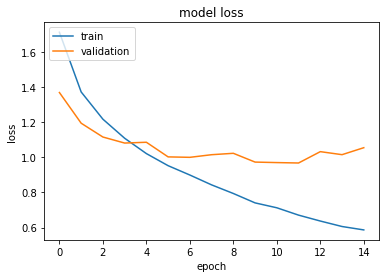

In [0]:
plotLosses(history)


### Batch normalization

[Batch Normalization](https://arxiv.org/abs/1502.03167) works by normalizing layer outputs to a running mean and variance. This speeds up training and improves the final performance of the model. The running statistics are fixed at test time.

While batch normalization works as a regularizer, it also benefits smaller models.

In [0]:
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=sgd)

In [0]:
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, verbose=2, validation_split=0.2)

Train on 40000 samples, validate on 10000 samples
Epoch 1/15
 - 8s - loss: 1.5985 - accuracy: 0.4320 - val_loss: 1.3024 - val_accuracy: 0.5285
Epoch 2/15
 - 7s - loss: 1.2489 - accuracy: 0.5560 - val_loss: 1.1648 - val_accuracy: 0.5817
Epoch 3/15
 - 7s - loss: 1.1072 - accuracy: 0.6076 - val_loss: 1.0899 - val_accuracy: 0.6171
Epoch 4/15
 - 7s - loss: 1.0120 - accuracy: 0.6412 - val_loss: 0.9190 - val_accuracy: 0.6783
Epoch 5/15
 - 7s - loss: 0.9470 - accuracy: 0.6671 - val_loss: 1.0257 - val_accuracy: 0.6489
Epoch 6/15
 - 7s - loss: 0.8888 - accuracy: 0.6867 - val_loss: 0.9688 - val_accuracy: 0.6675
Epoch 7/15
 - 7s - loss: 0.8452 - accuracy: 0.7022 - val_loss: 0.8696 - val_accuracy: 0.6984
Epoch 8/15
 - 7s - loss: 0.7977 - accuracy: 0.7175 - val_loss: 0.9171 - val_accuracy: 0.6853
Epoch 9/15
 - 7s - loss: 0.7601 - accuracy: 0.7327 - val_loss: 0.8515 - val_accuracy: 0.7057
Epoch 10/15
 - 7s - loss: 0.7270 - accuracy: 0.7407 - val_loss: 0.8744 - val_accuracy: 0.6968
Epoch 11/15
 - 7s -

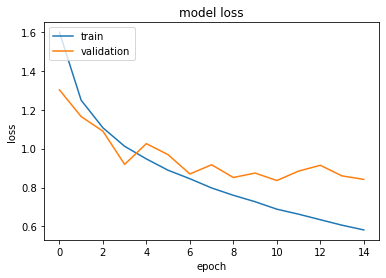

In [0]:
plotLosses(history)

### Evaluating the CNN (with dropout and batch normalization)

In [0]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)

In [0]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.8479275951385498, 0.7135000228881836]


### Data Augmentation


In [0]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True)   # flip images horizontally

validation_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train[:40000], y_train[:40000], batch_size=32)
validation_generator = validation_datagen.flow(X_train[40000:], y_train[40000:], batch_size=32)

In [0]:
from keras.optimizers import Adam

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Conv2D(32, (3, 3)))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
# Batch normalization layer added here
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

adam = Adam(lr=0.0006, beta_1=0.9, beta_2=0.999, decay=0.0)

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [0]:
# fits the model on batches with real-time data augmentation:
history = model.fit_generator(train_generator,    
                    validation_data=validation_generator,
                    validation_steps=len(X_train[40000:]) / 32,
                    steps_per_epoch=len(X_train[:40000]) / 32,
                    epochs=epochs,
                    verbose=2)

Epoch 1/15
 - 20s - loss: 1.6360 - accuracy: 0.4275 - val_loss: 1.3122 - val_accuracy: 0.4779
Epoch 2/15
 - 19s - loss: 1.3024 - accuracy: 0.5339 - val_loss: 1.2960 - val_accuracy: 0.4886
Epoch 3/15
 - 19s - loss: 1.1933 - accuracy: 0.5771 - val_loss: 1.2075 - val_accuracy: 0.5419
Epoch 4/15
 - 19s - loss: 1.1390 - accuracy: 0.5957 - val_loss: 0.7954 - val_accuracy: 0.6742
Epoch 5/15
 - 19s - loss: 1.1014 - accuracy: 0.6154 - val_loss: 0.9620 - val_accuracy: 0.6465
Epoch 6/15
 - 19s - loss: 1.0720 - accuracy: 0.6229 - val_loss: 0.6121 - val_accuracy: 0.6862
Epoch 7/15
 - 19s - loss: 1.0447 - accuracy: 0.6335 - val_loss: 0.5719 - val_accuracy: 0.6699
Epoch 8/15
 - 19s - loss: 1.0204 - accuracy: 0.6435 - val_loss: 0.9449 - val_accuracy: 0.7119
Epoch 9/15
 - 19s - loss: 0.9983 - accuracy: 0.6492 - val_loss: 0.9373 - val_accuracy: 0.6772
Epoch 10/15
 - 19s - loss: 0.9883 - accuracy: 0.6536 - val_loss: 0.7319 - val_accuracy: 0.6813
Epoch 11/15
 - 19s - loss: 0.9711 - accuracy: 0.6602 - val_

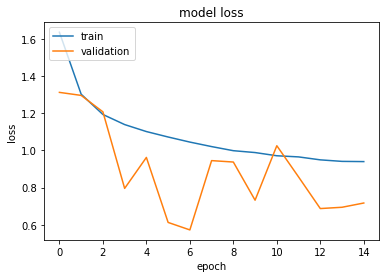

In [0]:
plotLosses(history)

### Evaluating the CNN (with dropout, batch normalization and data augmentation)

In [0]:
score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)


In [0]:
print(model.metrics_names)
print(score)

['loss', 'accuracy']
[0.8656789102554321, 0.6858000159263611]


**Reference:** 

https://towardsdatascience.com/cifar-10-image-classification-in-tensorflow-5b501f7dc77c

http://home.mit.bme.hu/~hadhazi/Oktatas/NN18/dem3/html_demo/CIFAR-10Demo.html

http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/11_NN_Regularization/11_NN_Regularization.html

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9

https://towardsdatascience.com/building-neural-network-from-scratch-9c88535bf8e9